<a href="https://colab.research.google.com/github/sucharitaatha/DataScience/blob/master/Univariate_Timeseries_using_GluonTS_DeepAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# GPU version
!pip install --upgrade mxnet-cu101==1.6.0.post0
# CPU version
#!pip install --upgrade mxnet==1.6.0
!pip install gluonts

In [36]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from gluonts.model.deepar import DeepAREstimator
# earlier used was - from gluonts.trainer import Trainer
from gluonts.mx.trainer import Trainer
import numpy as np

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


In [37]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

In [38]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [40]:
df.shape

(19735, 29)

In [41]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


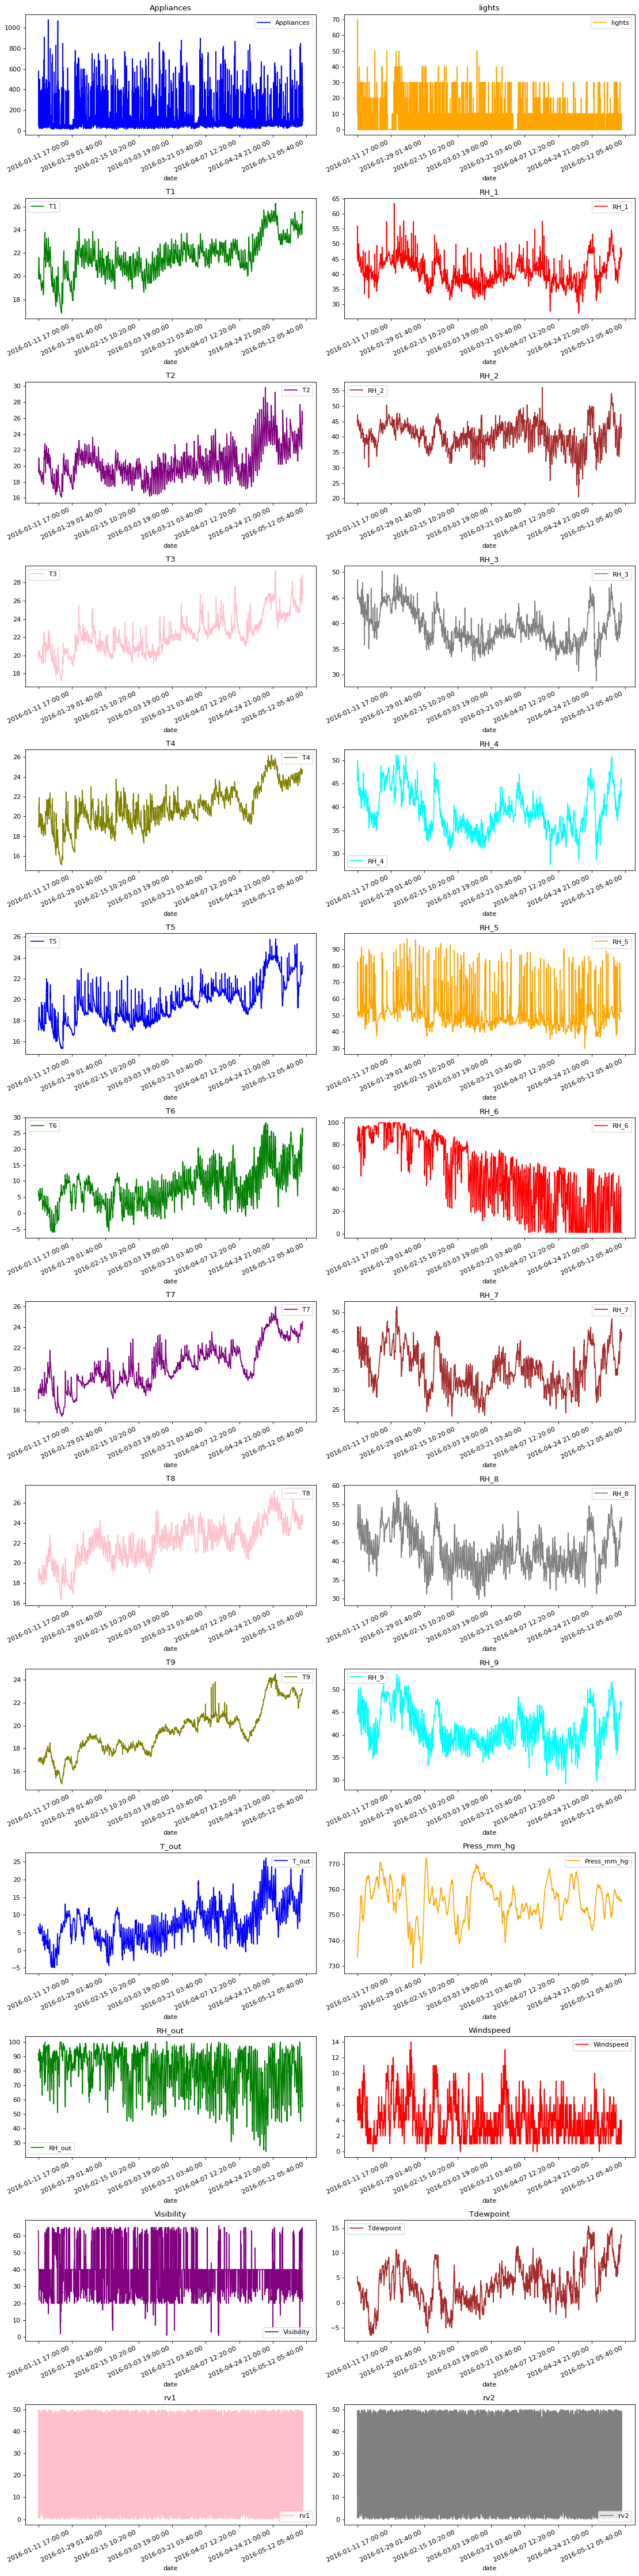

In [42]:
color_list = [
              "blue",
              "orange",
              "green",
              "red",
              "purple",
              "brown",
              "pink",
              "gray",
              "olive",
              "cyan",
]

date_key = "date"

def Visualize(data):
  time_data = data[date_key]
  features = list(df.select_dtypes(include=[np.number]).columns.values)
  feature_size=len(features)
  fig, axes = plt.subplots(
      nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
  )
  for i in range(feature_size):
    key = features[i]
    c = color_list[i % (len(color_list))]
    t_data = data[key]
    t_data.index = time_data
    t_data.head()
    ax = t_data.plot(
        ax=axes[i // 2, i % 2],
        color=c,
        title="{}".format(key),
        rot=25
    )
    ax.legend([key])
  plt.tight_layout()

Visualize(df)


In [43]:
df_input=df[['date', 'Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint', 'Visibility']]

In [44]:
df_input=df_input.set_index('date')

In [45]:
train_time="2016-05-10 00:00:00"
#prediction for 1 day, so 144 times, if 2 days, we can increase it
prediction_length=144

In [47]:
# context_lenght is previous 5 days of data and predicting next 1 day data
# Running for 8 epochs, by default it is 50 steps per epoch, but can be changed

estimator = DeepAREstimator(freq="10min",
                            context_length=720,
                            prediction_length=prediction_length,
                            num_layers=2,
                            num_cells=128,
                            cell_type='lstm',
                            trainer=Trainer(epochs=10))

In [48]:
# Univariate analysis

# Providing metadata to the existing data
from gluonts.dataset.common  import ListDataset

training_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Appliances[:train_time]}],
    freq = "10min"
)

In [49]:
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [03:30<00:00,  4.22s/it, epoch=10/10, avg_epoch_loss=4.33]


In [50]:
test_data = ListDataset(
    [
     {"start": df_input.index[0], "target": df_input.Appliances[:"2016-05-11 00:00:00"]},
     {"start": df_input.index[0], "target": df_input.Appliances[:"2016-05-15 00:00:00"]}
    ],
    freq = "10min"
)

In [51]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [52]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,
    predictor=predictor,
    num_samples=100,
)

In [53]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [54]:
forecast_entry = forecasts[0]

In [55]:
forecast_entry

gluonts.model.forecast.SampleForecast(freq="10min", info=None, item_id=None, samples=numpy.array([[46.33549118041992, 62.94414520263672, 52.824005126953125, 58.87699890136719, 72.62696075439453, 73.76597595214844, 57.923301696777344, 72.36408233642578, 56.78826904296875, 63.471248626708984, 69.36798095703125, 60.39235305786133, 56.44468688964844, 45.58271408081055, 64.4921875, 64.95171356201172, 41.61962127685547, 70.61182403564453, 60.12216567993164, 69.97354888916016, 70.4249038696289, 53.67369079589844, 60.761207580566406, 68.67608642578125, 49.65070724487305, 65.00202941894531, 77.93301391601562, 75.74028015136719, 112.2580337524414, 52.836875915527344, 66.91698455810547, 82.73028564453125, 75.80564880371094, 43.392513275146484, 68.5157699584961, 46.04467010498047, 73.7739028930664, 84.97340393066406, 79.57098388671875, 52.583656311035156, 56.513919830322266, 69.39302062988281, 69.91427612304688, 113.30572509765625, 112.3001708984375, 115.90676879882812, 147.94676208496094, 155.375

In [56]:
def plot_prob_forecasts(ts_entry, forecast_entry):
  plot_length = prediction_length
  prediction_intervals = (80.0, 95.0)
  legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

  fig, ax = plt.subplots(1, 1, figsize=(10, 7))
  ts_entry[-plot_length:].plot(ax=ax)
  forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
  plt.grid(which="both")
  plt.legend(legend, loc="upper left")
  plt.show()

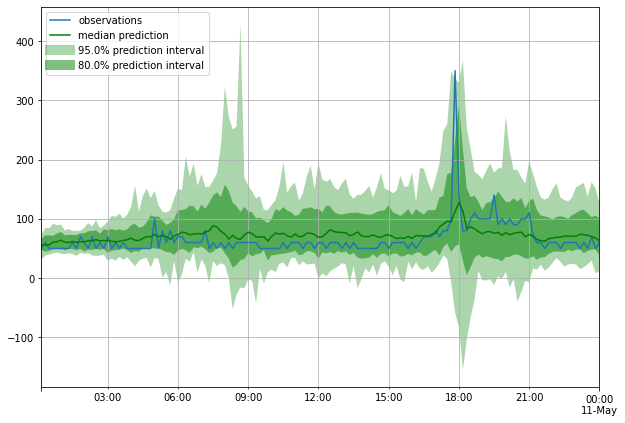

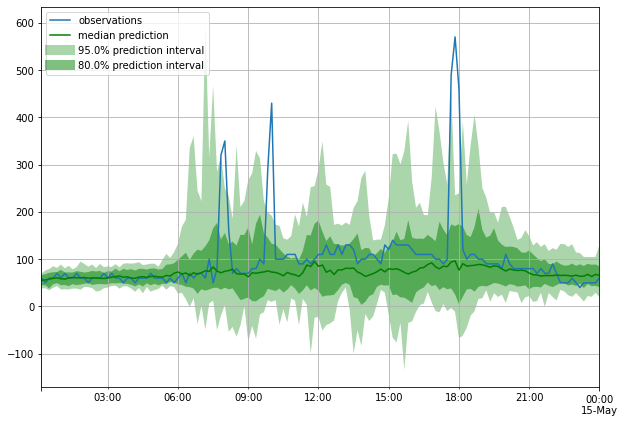

In [57]:
plot_prob_forecasts(tss[0], forecasts[0])
plot_prob_forecasts(tss[1], forecasts[1])

In [58]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 21.16it/s]


In [59]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,741.856337,2348.350098,9510.0,66.041667,64.962137,0.251038,0.245647,0.222965,2.321135,702.929955,0.041667,2348.350285,0.805556,1579.036063,0.986111
1,NaN,6037.430122,4784.712891,14350.0,99.652778,64.259270,0.517080,0.221504,0.264561,7.353652,1798.330846,0.013889,4784.712830,0.284722,4321.226941,0.888889
